**Chapter 2 – End-to-end Machine Learning project**

*Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.*

*This notebook contains all the sample code and solutions to the exercices in chapter 2.*

**Note**: You may find little differences between the code outputs in the book and in these Jupyter notebooks: these slight differences are mostly due to the random nature of many training algorithms: although I have tried to make these notebooks' outputs as constant as possible, it is impossible to guarantee that they will produce the exact same output on every platform. Also, some data structures (such as dictionaries) do not preserve the item order. Finally, I fixed a few minor bugs (I added notes next to the concerned cells) which lead to slightly different results, without changing the ideas presented in the book.

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# To make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Set run configurations
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    # Create path to where we should save the figure
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    # Adjust subplot params so that subplots are nicely fit in the figure
    if tight_layout:
        plt.tight_layout()
    # Save the current figure
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Get the data

In [2]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")

# https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    """
    Fetch housing data
    Args:
        housing_url (string): URL from where to download (defaults to HOUSING_URL)
        housing_path (string): Directory path to save the data (defaults to HOUSING_PATH)
    """
    # Create datasets/housing directory if it doesn't exist
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    # Create path to save the tar file
    tgz_path = os.path.join(housing_path, "housing.tgz")
    # Copy a network object denoted by a URL to a local file
    urllib.request.urlretrieve(housing_url, tgz_path)
    # Open the tar file
    housing_tgz = tarfile.open(tgz_path)
    # Extract all members from the archive to the housing_path 
    housing_tgz.extractall(path=housing_path)
    # Close the tar file
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    """
    Load the housing data
    Args:
        housing_path (string):Load the data from this path (defaults to HOUSING_PATH)
    """
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
# DataFrame description
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
# Categorical variable
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
# Statistical analysis
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Saving figure attribute_histogram_plots


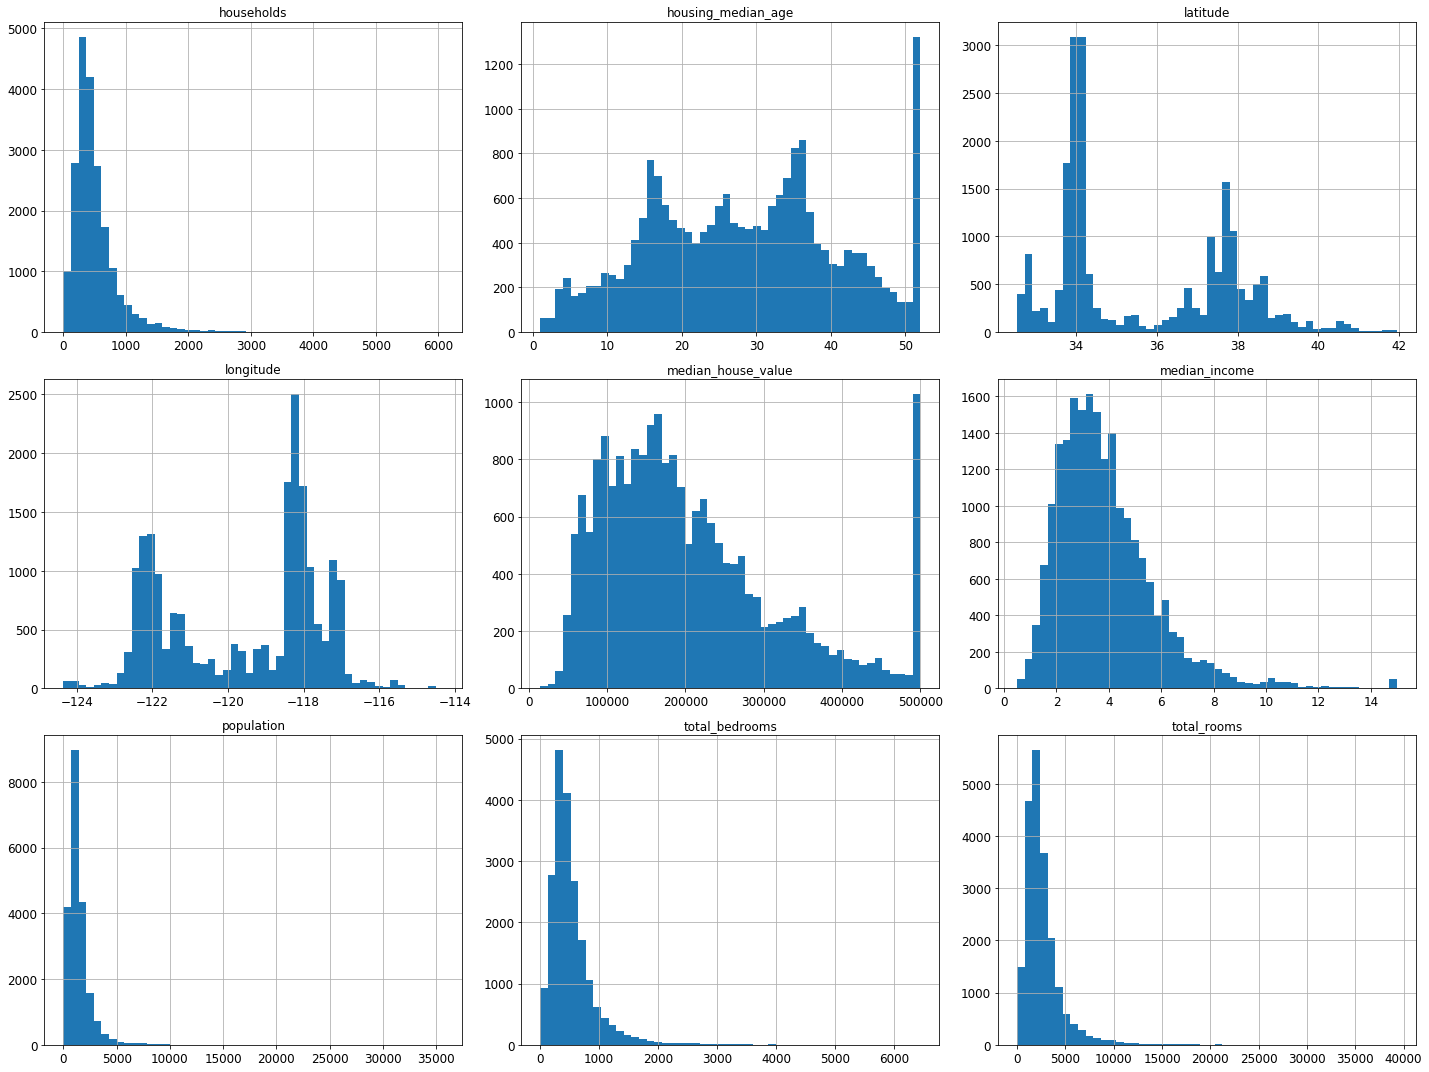

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
# Plot histogram
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

In [10]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [11]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    """
    Manual implementation to split data into train set and test set
    Args:
        data: Data to split
        test_ratio: Ratio of splitting data
    Returns:
        Train set and test set
    """
    # Shuffle the indices of data
    shuffled_indices = np.random.permutation(len(data))
    # Calculate test set size
    test_set_size = int(len(data) * test_ratio)
    # Get the test indices
    test_indices = shuffled_indices[:test_set_size]
    # Get the train indices
    train_indices = shuffled_indices[test_set_size:]
    # Return the train data based on train indices
    # and test data based on test indices
    return data.iloc[train_indices], data.iloc[test_indices]

In [12]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [13]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    # np.int64 to convert to numbers
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    """
    Split data by id
    Args:
        data: Data to split
        test_ratio: Ratio of split
        id_column: Name of the id column
    Returns: 
        Train set and test set
    """
    # Get the Series of ids
    ids = data[id_column]
    # Apply the test_set_check method to ids Series
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    # Return train data based on indices not in in_test_set
    # and test data based on indices in in_test_set
    return data.loc[~in_test_set], data.loc[in_test_set]

The implementation of `test_set_check()` above works fine in both Python 2 and Python 3. In earlier releases, the following implementation was proposed, which supported any hash function, but was much slower and did not support Python 2:

In [14]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

If you want an implementation that supports any hash function and is compatible with both Python 2 and Python 3, here is one:

In [15]:
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [16]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [17]:
# Building an unique identifier
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [18]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


In [19]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [20]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


## Analyze median income

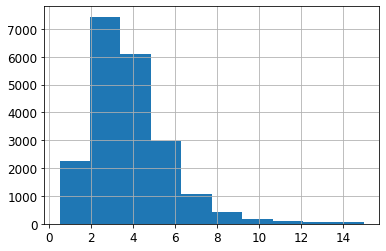

In [21]:
housing["median_income"].hist()

In [22]:
# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] > 5, 5.0, inplace=True)

In [23]:
housing["income_cat"].value_counts()

5.0     19701
6.0       532
7.0       189
8.0       105
9.0        50
11.0       49
10.0       14
Name: income_cat, dtype: int64

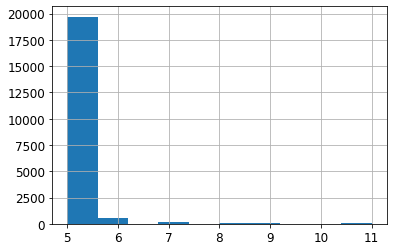

In [24]:
housing["income_cat"].hist()

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    print("TRAIN:", train_index, "TEST:", test_index)
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

TRAIN: [16659 19735  1566 ... 17850  5084 19394] TEST: [  728 10715  7608 ...  9627  4739 11550]


In [26]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

5.0     0.954457
6.0     0.025678
7.0     0.009205
8.0     0.005087
11.0    0.002422
9.0     0.002422
10.0    0.000727
Name: income_cat, dtype: float64

In [27]:
housing["income_cat"].value_counts() / len(housing)

5.0     0.954506
6.0     0.025775
7.0     0.009157
8.0     0.005087
9.0     0.002422
11.0    0.002374
10.0    0.000678
Name: income_cat, dtype: float64

In [28]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [29]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
5.0,0.954506,0.954457,0.955426,0.096442,-0.005076
6.0,0.025775,0.025678,0.024709,-4.135338,-0.375940
7.0,0.009157,0.009205,0.008721,-4.761905,0.529101
8.0,0.005087,0.005087,0.005572,9.523810,0.000000
9.0,0.002422,0.002422,0.002665,10.000000,0.000000
10.0,0.000678,0.000727,0.000969,42.857143,7.142857
11.0,0.002374,0.002422,0.001938,-18.367347,2.040816


In [30]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Discover and visualize the data to gain insights

In [31]:
# Create a copy of the tratified training set
housing = strat_train_set.copy()

Saving figure bad_visualization_plot


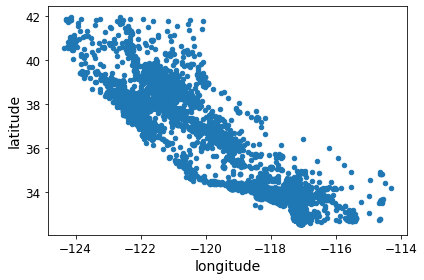

In [32]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

Saving figure better_visualization_plot


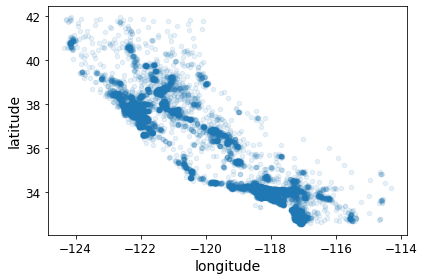

In [33]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

The argument `sharex=False` fixes a display bug (the x-axis values and legend were not displayed). This is a temporary fix (see: https://github.com/pandas-dev/pandas/issues/10611). Thanks to Wilmer Arellano for pointing it out.

Saving figure housing_prices_scatterplot


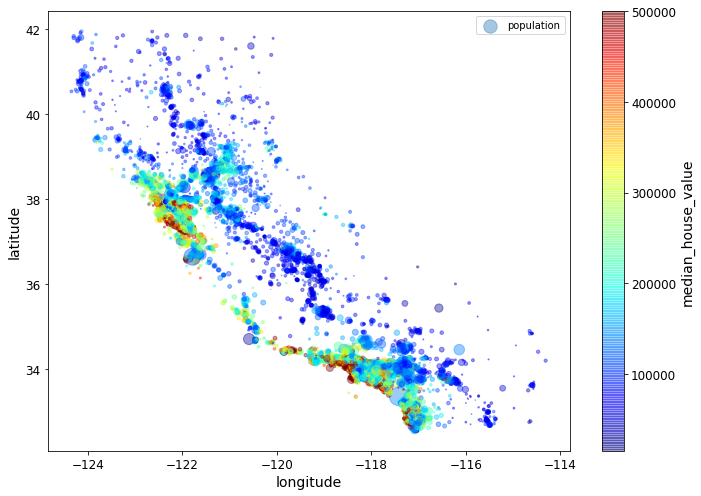

In [34]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

Saving figure california_housing_prices_plot


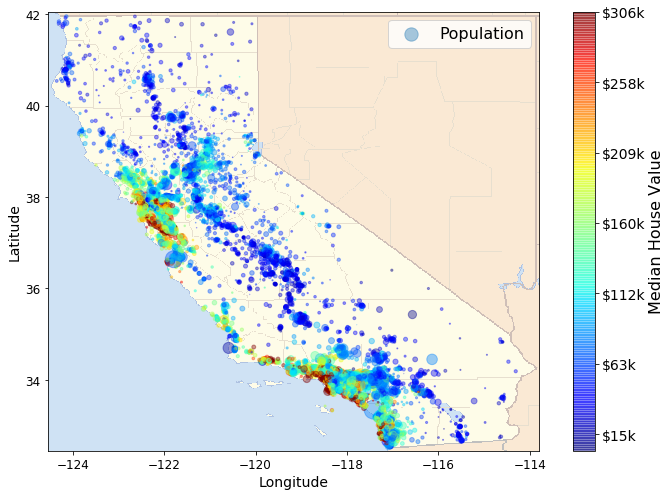

In [35]:
import matplotlib.image as mpimg
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/images/end_to_end_project/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

In [36]:
corr_matrix = housing.corr()

In [37]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.686214
total_rooms           0.132777
housing_median_age    0.104035
households            0.065741
total_bedrooms        0.050092
population           -0.024797
longitude            -0.050312
latitude             -0.140169
Name: median_house_value, dtype: float64

Saving figure scatter_matrix_plot


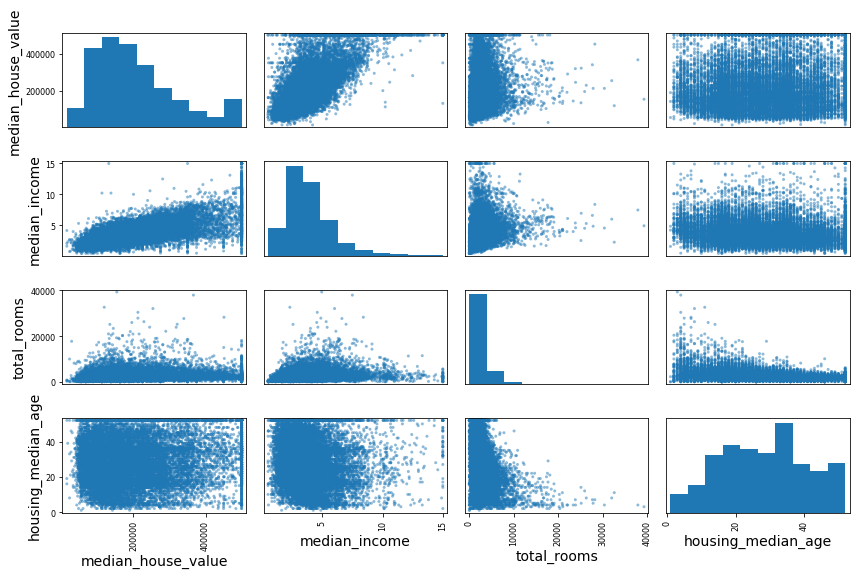

In [38]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

Saving figure income_vs_house_value_scatterplot


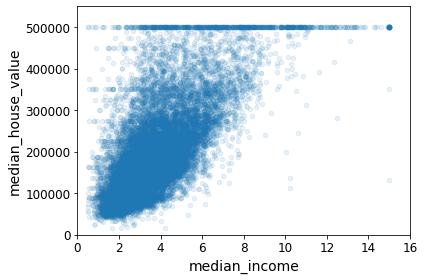

In [39]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

In [38]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

Note: there was a bug in the previous cell, in the definition of the `rooms_per_household` attribute. This explains why the correlation value below differs slightly from the value in the book (unless you are reading the latest version).

In [41]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
income_cat                  0.643892
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

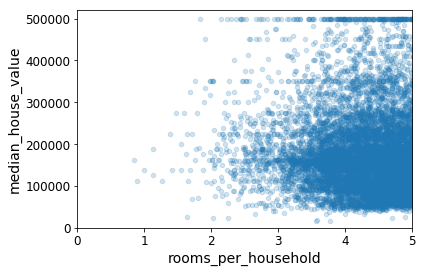

In [42]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [40]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16346.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.567739,35.625042,28.620094,2642.931928,539.535605,1429.702701,501.295845,3.870025,207520.656856
std,2.003392,2.130721,12.616845,2198.599417,424.418242,1155.262146,385.924073,1.900115,115669.426606
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.000000,296.000000,786.750000,280.000000,2.565175,120400.000000
50%,-118.490000,34.255000,29.000000,2125.000000,433.500000,1165.000000,409.000000,3.529600,181100.000000
75%,-118.010000,37.710000,37.000000,3156.000000,648.000000,1726.000000,606.000000,4.740050,265600.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


# Prepare the data for Machine Learning algorithms

In [41]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

## Handling numerical attributes

In [42]:
# Get records with null values
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
6421,-117.99,34.14,30.0,2346.0,NaN,1988.0,474.0,2.5625,INLAND
7547,-118.20,33.92,45.0,1283.0,NaN,1025.0,248.0,3.2798,<1H OCEAN
9622,-120.32,37.29,38.0,576.0,NaN,478.0,112.0,2.3382,INLAND
16105,-122.50,37.75,44.0,1819.0,NaN,1137.0,354.0,3.4919,NEAR OCEAN
3778,-118.40,34.17,24.0,6347.0,NaN,2945.0,1492.0,3.3545,<1H OCEAN


In [43]:
## Various strategies to get rid of na values
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [44]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
6421,-117.99,34.14,30.0,2346.0,1988.0,474.0,2.5625,INLAND
7547,-118.20,33.92,45.0,1283.0,1025.0,248.0,3.2798,<1H OCEAN
9622,-120.32,37.29,38.0,576.0,478.0,112.0,2.3382,INLAND
16105,-122.50,37.75,44.0,1819.0,1137.0,354.0,3.4919,NEAR OCEAN
3778,-118.40,34.17,24.0,6347.0,2945.0,1492.0,3.3545,<1H OCEAN


In [45]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
6421,-117.99,34.14,30.0,2346.0,433.5,1988.0,474.0,2.5625,INLAND
7547,-118.20,33.92,45.0,1283.0,433.5,1025.0,248.0,3.2798,<1H OCEAN
9622,-120.32,37.29,38.0,576.0,433.5,478.0,112.0,2.3382,INLAND
16105,-122.50,37.75,44.0,1819.0,433.5,1137.0,354.0,3.4919,NEAR OCEAN
3778,-118.40,34.17,24.0,6347.0,433.5,2945.0,1492.0,3.3545,<1H OCEAN


**Warning**: Since Scikit-Learn 0.20, the `sklearn.preprocessing.Imputer` class was replaced by the `sklearn.impute.SimpleImputer` class.

In [46]:
# Take care of missing values using SimpleImputer
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer
# Create an instance of SimpleImputer with the median strategy
imputer = SimpleImputer(strategy="median")

Remove the text attribute because median can only be calculated on numerical attributes:

In [47]:
housing_num = housing.drop('ocean_proximity', axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [48]:
# Fit the data to the imputer
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [49]:
# Returns a list of strategic (in this case median) values for each attributer
imputer.statistics_

array([-118.49  ,   34.255 ,   29.    , 2125.    ,  433.5   , 1165.    ,
        409.    ,    3.5296])

Check that this is the same as manually computing the median of each attribute:

In [50]:
housing_num.median().values

array([-118.49  ,   34.255 ,   29.    , 2125.    ,  433.5   , 1165.    ,
        409.    ,    3.5296])

Transform the training set:

In [51]:
# Transform the training set using imputer.transform
X = imputer.transform(housing_num)

In [52]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index = list(housing.index.values))

In [53]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
6421,-117.99,34.14,30.0,2346.0,433.5,1988.0,474.0,2.5625
7547,-118.20,33.92,45.0,1283.0,433.5,1025.0,248.0,3.2798
9622,-120.32,37.29,38.0,576.0,433.5,478.0,112.0,2.3382
16105,-122.50,37.75,44.0,1819.0,433.5,1137.0,354.0,3.4919
3778,-118.40,34.17,24.0,6347.0,433.5,2945.0,1492.0,3.3545


In [54]:
imputer.strategy

'median'

In [55]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-120.67,35.30,32.0,4202.0,986.0,2309.0,956.0,2.2165
1,-121.80,40.34,26.0,4815.0,910.0,1341.0,539.0,2.8810
2,-121.96,37.74,2.0,200.0,20.0,25.0,9.0,15.0001
3,-121.35,38.09,32.0,1706.0,292.0,923.0,284.0,5.5057
4,-118.15,34.59,33.0,2111.0,429.0,1067.0,397.0,3.7344


Now let's preprocess the categorical input feature, `ocean_proximity`:

## Handling text and categorical attributes

In [56]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
16659,NEAR OCEAN
19735,INLAND
1566,<1H OCEAN
16430,INLAND
9111,INLAND
4803,<1H OCEAN
6711,<1H OCEAN
10229,<1H OCEAN
19327,<1H OCEAN
10519,<1H OCEAN


**Warning**: earlier versions of the book used the `LabelEncoder` class or Pandas' `Series.factorize()` method to encode string categorical attributes as integers. However, the `OrdinalEncoder` class that was introduced in Scikit-Learn 0.20 (see [PR #10521](https://github.com/scikit-learn/scikit-learn/issues/10521)) is preferable since it is designed for input features (`X` instead of labels `y`) and it plays well with pipelines (introduced later in this notebook). If you are using an older version of Scikit-Learn (<0.20), then you can import it from `future_encoders.py` instead.

In [57]:
try:
    from sklearn.preprocessing import OrdinalEncoder
except ImportError:
    from future_encoders import OrdinalEncoder # Scikit-Learn < 0.20

In [58]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[4.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [59]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

**Warning**: earlier versions of the book used the `LabelBinarizer` or `CategoricalEncoder` classes to convert each categorical value to a one-hot vector. It is now preferable to use the `OneHotEncoder` class. Since Scikit-Learn 0.20 it can handle string categorical inputs (see [PR #10521](https://github.com/scikit-learn/scikit-learn/issues/10521)), not just integer categorical inputs. If you are using an older version of Scikit-Learn, you can import the new version from `future_encoders.py`:

In [60]:
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [61]:
# Convert into a NumPy array
housing_cat_1hot.toarray()

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [62]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [63]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Let's create a custom transformer to add extra attributes:

In [64]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            # Concatenates along the second axis
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [65]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-120.67,35.3,32,4202,986,2309,956,2.2165,NEAR OCEAN,4.3954,2.41527
1,-121.8,40.34,26,4815,910,1341,539,2.881,INLAND,8.93321,2.48794
2,-121.96,37.74,2,200,20,25,9,15.0001,<1H OCEAN,22.2222,2.77778
3,-121.35,38.09,32,1706,292,923,284,5.5057,INLAND,6.00704,3.25
4,-118.15,34.59,33,2111,429,1067,397,3.7344,INLAND,5.31738,2.68766


Now let's build a pipeline for preprocessing the numerical attributes:

In [66]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        # Replace all na values with median value of the column
        ('imputer', SimpleImputer(strategy="median")),
        # Add new attributes
        ('attribs_adder', CombinedAttributesAdder()),
        # Feature scaling
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [67]:
housing_num_tr

array([[-5.50214296e-01, -1.52554734e-01,  2.67896442e-01, ...,
        -4.51710498e-01, -6.10223676e-02,  3.09900007e-01],
       [-1.11427484e+00,  2.21291300e+00, -2.07672665e-01, ...,
         1.56718270e+00, -5.41865727e-02, -3.74804330e-01],
       [-1.19414182e+00,  9.92632026e-01, -2.10994909e+00, ...,
         7.47952462e+00, -2.69221759e-02, -1.70938890e+00],
       ...,
       [-1.15420833e+00,  8.51830375e-01, -9.21026325e-01, ...,
         5.41573976e-02,  4.18184423e-02, -4.42869058e-01],
       [ 6.37807022e-01, -7.72081998e-01,  1.37755769e+00, ...,
        -4.48962183e-01,  2.87013483e-03,  8.15076251e-01],
       [-6.30081275e-01,  1.00671219e+00, -6.83241772e-01, ...,
        -5.02252533e-01, -3.90944534e-02,  3.10822893e-01]])

**Warning**: earlier versions of the book applied different transformations to different columns using a solution based on a `DataFrameSelector` transformer and a `FeatureUnion` (see below). It is now preferable to use the `ColumnTransformer` class that was introduced in Scikit-Learn 0.20. If you are using an older version of Scikit-Learn, you can import it from `future_encoders.py`:

In [71]:
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

In [72]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

# Create a ColumnTransformer to apply transformation to
# numerical attributes and categorical attributes at a time
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [73]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [74]:
housing_prepared.shape

(16512, 16)

For reference, here is the old solution based on a `DataFrameSelector` transformer (to just select a subset of the Pandas `DataFrame` columns), and a `FeatureUnion`:

In [75]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Now let's join all these components into a big pipeline that will preprocess both the numerical and the categorical features:

In [76]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [77]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [78]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

The result is the same as with the `ColumnTransformer`:

In [79]:
np.allclose(housing_prepared, old_housing_prepared)

True

# Select and train a model 

In [80]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [81]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


Compare against the actual values:

In [82]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [83]:
some_data_prepared

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

In [84]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

In [85]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001897

In [86]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [87]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

# Fine-tune your model

In [88]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [89]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Mean: 71407.68766037929
Standard deviation: 2439.4345041191004


In [90]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798348


**Note**: we specify `n_estimators=10` to avoid a warning about the fact that the default value is going to change to 100 in Scikit-Learn 0.22.

In [91]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [92]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21933.31414779769

In [93]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51646.44545909 48940.60114882 53050.86323649 54408.98730149
 50922.14870785 56482.50703987 51864.52025526 49760.85037653
 55434.21627933 53326.10093303]
Mean: 52583.72407377466
Standard deviation: 2298.353351147122


In [94]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69052.461363
std       2879.437224
min      64969.630564
25%      67136.363758
50%      68156.372635
75%      70982.369487
max      74739.570526
dtype: float64

In [95]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

In [96]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

The best hyperparameter combination found:

In [97]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [98]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [99]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.05791727153 {'max_features': 2, 'n_estimators': 3}
55627.16171305252 {'max_features': 2, 'n_estimators': 10}
53384.57867637289 {'max_features': 2, 'n_estimators': 30}
60965.99185930139 {'max_features': 4, 'n_estimators': 3}
52740.98248528835 {'max_features': 4, 'n_estimators': 10}
50377.344409590376 {'max_features': 4, 'n_estimators': 30}
58663.84733372485 {'max_features': 6, 'n_estimators': 3}
52006.15355973719 {'max_features': 6, 'n_estimators': 10}
50146.465964159885 {'max_features': 6, 'n_estimators': 30}
57869.25504027614 {'max_features': 8, 'n_estimators': 3}
51711.09443660957 {'max_features': 8, 'n_estimators': 10}
49682.25345942335 {'max_features': 8, 'n_estimators': 30}
62895.088889905004 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.14484390074 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.399594730654 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52725.01091081235 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [100]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.060251,0.001252,0.004077,0.000397,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.837622e+09,-4.147108e+09,...,-4.053749e+09,1.519609e+08,18,-1.064113e+09,-1.105142e+09,-1.116550e+09,-1.112342e+09,-1.129650e+09,-1.105559e+09,2.220402e+07
1,0.195211,0.001845,0.010179,0.000394,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.047771e+09,-3.254861e+09,...,-3.094381e+09,1.327046e+08,11,-5.927175e+08,-5.870952e+08,-5.776964e+08,-5.716332e+08,-5.802501e+08,-5.818785e+08,7.345821e+06
2,0.589625,0.003846,0.030403,0.003266,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.689185e+09,-3.021086e+09,...,-2.849913e+09,1.626879e+08,9,-4.381089e+08,-4.391272e+08,-4.371702e+08,-4.376955e+08,-4.452654e+08,-4.394734e+08,2.966320e+06
3,0.098321,0.001313,0.003398,0.000078,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.730181e+09,-3.786886e+09,...,-3.716852e+09,1.631421e+08,16,-9.865163e+08,-1.012565e+09,-9.169425e+08,-1.037400e+09,-9.707739e+08,-9.848396e+08,4.084607e+07
4,0.322361,0.002503,0.010031,0.000395,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.666283e+09,-2.784511e+09,...,-2.781611e+09,1.268562e+08,8,-5.097115e+08,-5.162820e+08,-4.962893e+08,-5.436192e+08,-5.160297e+08,-5.163863e+08,1.542862e+07
5,0.964709,0.003208,0.026985,0.000617,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.387153e+09,-2.588448e+09,...,-2.537877e+09,1.214603e+08,3,-3.838835e+08,-3.880268e+08,-3.790867e+08,-4.040957e+08,-3.845520e+08,-3.879289e+08,8.571233e+06
6,0.132895,0.003371,0.003408,0.000064,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.119657e+09,-3.586319e+09,...,-3.441447e+09,1.893141e+08,14,-9.245343e+08,-8.886939e+08,-9.353135e+08,-9.009801e+08,-8.624664e+08,-9.023976e+08,2.591445e+07
7,0.443695,0.005027,0.010141,0.000682,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.549663e+09,-2.782039e+09,...,-2.704640e+09,1.471542e+08,6,-4.980344e+08,-5.045869e+08,-4.994664e+08,-4.990325e+08,-5.055542e+08,-5.013349e+08,3.100456e+06
8,1.343336,0.004695,0.027562,0.001805,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.370010e+09,-2.583638e+09,...,-2.514668e+09,1.285063e+08,2,-3.838538e+08,-3.804711e+08,-3.805218e+08,-3.856095e+08,-3.901917e+08,-3.841296e+08,3.617057e+06
9,0.169927,0.001055,0.003458,0.000110,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.353504e+09,-3.348552e+09,...,-3.348851e+09,1.241864e+08,13,-9.228123e+08,-8.553031e+08,-8.603321e+08,-8.881964e+08,-9.151287e+08,-8.883545e+08,2.750227e+07


In [101]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)

# When the hyperparameter search space is large use RandomizedSearchCV,
# which instead of trying out all possible combinations, it evaluates
# a given number of random combinations by selecting a random value
# for each hyperparameter at every iteation
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1210939e8>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x121093710>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [102]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.657232934034 {'max_features': 7, 'n_estimators': 180}
51389.85295710133 {'max_features': 5, 'n_estimators': 15}
50796.12045980556 {'max_features': 3, 'n_estimators': 72}
50835.09932039744 {'max_features': 5, 'n_estimators': 21}
49280.90117886215 {'max_features': 7, 'n_estimators': 122}
50774.86679035961 {'max_features': 3, 'n_estimators': 75}
50682.75001237282 {'max_features': 3, 'n_estimators': 88}
49608.94061293652 {'max_features': 5, 'n_estimators': 100}
50473.57642831875 {'max_features': 3, 'n_estimators': 150}
64429.763804893395 {'max_features': 5, 'n_estimators': 2}


In [103]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [104]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3661589806181342, 'median_income'),
 (0.1647809935615905, 'INLAND'),
 (0.10879295677551573, 'pop_per_hhold'),
 (0.07334423551601242, 'longitude'),
 (0.0629090704826203, 'latitude'),
 (0.05641917918195401, 'rooms_per_hhold'),
 (0.05335107734767581, 'bedrooms_per_room'),
 (0.041143798478729635, 'housing_median_age'),
 (0.014874280890402767, 'population'),
 (0.014672685420543237, 'total_rooms'),
 (0.014257599323407807, 'households'),
 (0.014106483453584102, 'total_bedrooms'),
 (0.010311488326303787, '<1H OCEAN'),
 (0.002856474637320158, 'NEAR OCEAN'),
 (0.00196041559947807, 'NEAR BAY'),
 (6.028038672736599e-05, 'ISLAND')]

In [105]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [106]:
final_rmse

47730.22690385927

We can compute a 95% confidence interval for the test RMSE:

In [107]:
from scipy import stats

In [108]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

array([45685.10470776, 49691.25001878])

We could compute the interval manually like this:

In [109]:
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(45685.10470776014, 49691.25001877871)

Alternatively, we could use a z-scores rather than t-scores:

In [110]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(45685.717918136594, 49690.68623889426)

# Extra material

## A full pipeline with both preparation and prediction

In [111]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

## Model persistence using joblib

In [112]:
my_model = full_pipeline_with_predictor

In [113]:
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

## Example SciPy distributions for `RandomizedSearchCV`

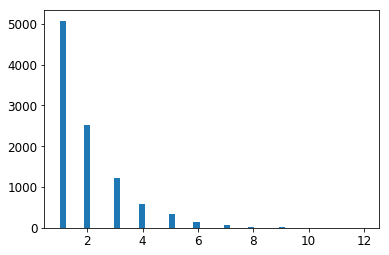

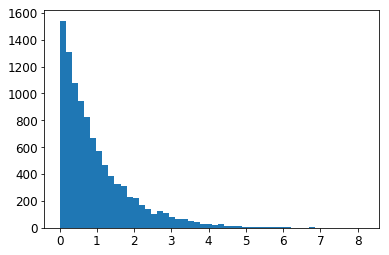

In [114]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

# Exercise solutions

## 1.

Question: Try a Support Vector Machine regressor (`sklearn.svm.SVR`), with various hyperparameters such as `kernel="linear"` (with various values for the `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). Don't worry about what these hyperparameters mean for now. How does the best `SVR` predictor perform?

In [115]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  9.4min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 15.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid=[{'kernel': ['linear'], 'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0, 30000.0]}, {'kernel': ['rbf'], 'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0], 'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [116]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70363.90313964167

That's much worse than the `RandomForestRegressor`. Let's check the best hyperparameters found:

In [117]:
grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

The linear kernel seems better than the RBF kernel. Notice that the value of `C` is the maximum tested value. When this happens you definitely want to launch the grid search again with higher values for `C` (removing the smallest values), because it is likely that higher values of `C` will be better.

## 2.

Question: Try replacing `GridSearchCV` with `RandomizedSearchCV`.

In [118]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 12.1min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 19.6min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=4,
          param_distributions={'kernel': ['linear', 'rbf'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x13a243278>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x13a243e48>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [119]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

54767.99053704408

Now this is much closer to the performance of the `RandomForestRegressor` (but not quite there yet). Let's check the best hyperparameters found:

In [120]:
rnd_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

This time the search found a good set of hyperparameters for the RBF kernel. Randomized search tends to find better hyperparameters than grid search in the same amount of time.

Let's look at the exponential distribution we used, with `scale=1.0`. Note that some samples are much larger or smaller than 1.0, but when you look at the log of the distribution, you can see that most values are actually concentrated roughly in the range of exp(-2) to exp(+2), which is about 0.1 to 7.4.

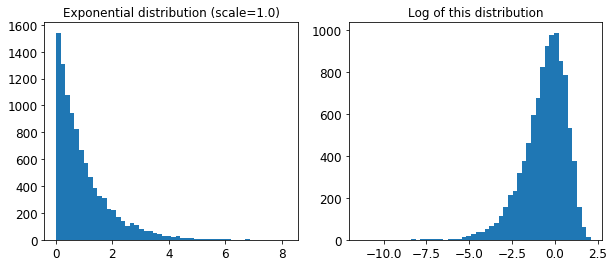

In [121]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The distribution we used for `C` looks quite different: the scale of the samples is picked from a uniform distribution within a given range, which is why the right graph, which represents the log of the samples, looks roughly constant. This distribution is useful when you don't have a clue of what the target scale is:

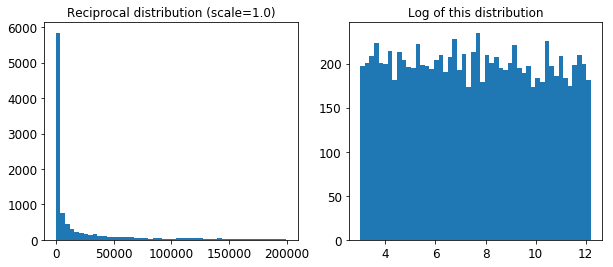

In [122]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The reciprocal distribution is useful when you have no idea what the scale of the hyperparameter should be (indeed, as you can see on the figure on the right, all scales are equally likely, within the given range), whereas the exponential distribution is best when you know (more or less) what the scale of the hyperparameter should be.

## 3.

Question: Try adding a transformer in the preparation pipeline to select only the most important attributes.

In [123]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

Note: this feature selector assumes that you have already computed the feature importances somehow (for example using a `RandomForestRegressor`). You may be tempted to compute them directly in the `TopFeatureSelector`'s `fit()` method, however this would likely slow down grid/randomized search since the feature importances would have to be computed for every hyperparameter combination (unless you implement some sort of cache).

Let's define the number of top features we want to keep:

In [124]:
k = 5

Now let's look for the indices of the top k features:

In [125]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  1,  7,  9, 12])

In [126]:
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'latitude', 'median_income', 'pop_per_hhold',
       'INLAND'], dtype='<U18')

Let's double check that these are indeed the top k features:

In [127]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.3661589806181342, 'median_income'),
 (0.1647809935615905, 'INLAND'),
 (0.10879295677551573, 'pop_per_hhold'),
 (0.07334423551601242, 'longitude'),
 (0.0629090704826203, 'latitude')]

Looking good... Now let's create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection:

In [128]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [129]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

Let's look at the features of the first 3 instances:

In [130]:
housing_prepared_top_k_features[0:3]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

Now let's double check that these are indeed the top k features:

In [131]:
housing_prepared[0:3, top_k_feature_indices]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

Works great!  :)

## 4.

Question: Try creating a single pipeline that does the full data preparation plus the final prediction.

In [132]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [133]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(memory=None,
     steps=[('preparation', ColumnTransformer(n_jobs=1, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0... gamma=0.26497040005002437, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))])

Let's try the full pipeline on a few instances:

In [134]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [203214.28978849 371846.88152572 173295.65441612  47328.3970888 ]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0]


Well, the full pipeline seems to work fine. Of course, the predictions are not fantastic: they would be better if we used the best `RandomForestRegressor` that we found earlier, rather than the best `SVR`.

## 5.

Question: Automatically explore some preparation options using `GridSearchCV`.

In [136]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  9.7min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed: 19.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preparation', ColumnTransformer(n_jobs=1, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0... gamma=0.26497040005002437, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid=[{'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'], 'feature_selection__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [137]:
grid_search_prep.best_params_

{'feature_selection__k': 15,
 'preparation__num__imputer__strategy': 'most_frequent'}

The best imputer strategy is `most_frequent` and apparently almost all features are useful (15 out of 16). The last one (`ISLAND`) seems to just add some noise.

Congratulations! You already know quite a lot about Machine Learning. :)